# Evaluate test set performance and compare to RosettaSurf
Import the separate test set based on the dataset used in the RosettaSurf publication. Contains 200 * 20 residues.
Evaluate best model on this data.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [2]:
#import os
from datetime import datetime
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import tensorboard
import torchvision

In [3]:
# Set seed for life
torch.manual_seed(42)
np.random.seed(42)

In [6]:
res2num = {
        "ALA": 0, 
        "ASX": 1, 
        "CYS": 2, 
        "ASP": 3, 
        "GLU": 4, 
        "PHE": 5, 
        "GLY": 6, 
        "HIS": 7,
        "ILE": 8, 
        "LYS": 9, 
        "LEU": 10, 
        "MET": 11, 
        "ASN": 12, 
        "PRO": 13, 
        "GLN": 14,
        "ARG": 15, 
        "SER": 16, 
        "THR": 17, 
        "SEC": 18, 
        "VAL": 19, 
        "TRP": 20, 
        "XAA": 21,
        "TYR": 22, 
        "GLX": 23}
    
old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN", 
             "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA","TYR", "GLX"]

In [7]:
X_te = np.load('../data/dataset/test_feats.npy').astype(np.float32)
X_te = X_te.reshape(X_te.shape[0], X_te.shape[1] * X_te.shape[2])
y_te = np.load('../data/dataset/test_target.npy').astype(np.int64)

        
X_te_old = X_te
n_obs = y_te.shape[0]
nonzero_index = (~np.all(y_te == 0, axis = 0)).nonzero()[0]
names = []
for i in nonzero_index:
    names.append(old_names[i])

# Then remove zero columns from 'y_te'
y_te = y_te[:,~np.all(y_te == 0, axis = 0)]

# Scale features
scaler = StandardScaler()
X_te_scaled = scaler.fit_transform(X_te_old)
# Added theta, so now 29 instead of 28 features per point
X_te = X_te_scaled.reshape(n_obs, 50, 37)
# Get integer values from one-hot encoding
y_te_int = np.array([], dtype = np.int64)
for i in y_te:
    y_te_int = np.concatenate((y_te_int, np.nonzero(i)[0]))

# Save float and unique array_tes of y_te_int
y_te_float = y_te_int
unique_y_te = np.unique(y_te_float)
X_te_data = torch.from_numpy(X_te)
y_te_data = torch.from_numpy(y_te_int)

In [8]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 50, 1, stride=1)
        self.drop_layer_1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(50, 10)
        self.drop_layer_2 = nn.Dropout(p=0.8)
        self.layer3 = nn.Linear(500, 100)
        self.layer4 = nn.Linear(100, 20)
        

        
    def forward(self, x):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = self.drop_layer_1(x)
        x = F.relu(self.layer2(x))
        x = x.view(-1,10*50)
        x = self.drop_layer_2(x) # dropout module
        x = F.relu(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        
        return x

In [34]:
model = Model(X_te.shape[2])
model.load_state_dict(torch.load('../models/model_0_2021_12_23-12:28:28_AM.pth'))
model.eval()

Model(
  (layer1): Conv1d(37, 50, kernel_size=(1,), stride=(1,))
  (drop_layer_1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
  (drop_layer_2): Dropout(p=0.8, inplace=False)
  (layer3): Linear(in_features=500, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=20, bias=True)
)

In [35]:
model(X_te_data)[y_te_int == i].shape

/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([199, 20])

In [36]:
sns.set_style("whitegrid")

/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: 

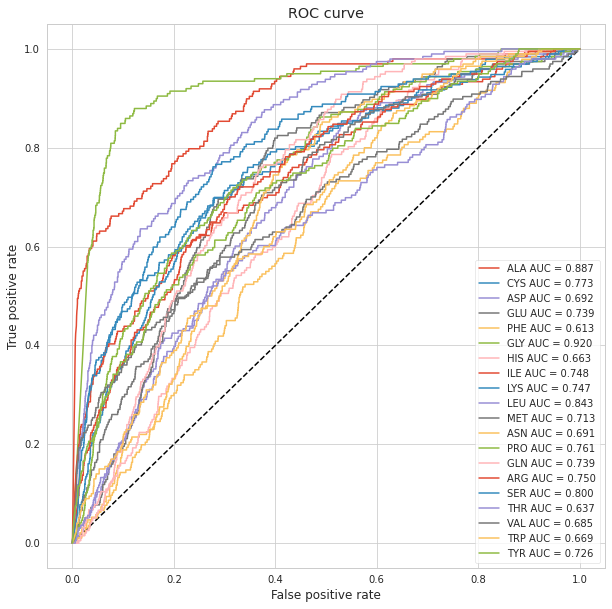

In [37]:
# Do a ROC plot for each amino acid
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_te_int[:, np.newaxis]).toarray()
for i in range(len(np.unique(y_te_int))):
    
    with torch.no_grad():
        y_pre = (model(X_te_data)[y_te_int == i]).numpy()
        Y_one = Y_onehot[y_te_data == i]
        fpr, tpr, threshold = roc_curve(Y_one.ravel(), y_pre.ravel())
    
    plt.plot(fpr, tpr, label=names[i] + ' AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

## Load Rosetta data, results and barplot + confusion matrix

In [ ]:
bound_recover_ala = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_ala.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_arg = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_arg.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_asn = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_asn.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_asp = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_asp.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_cys = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_cys.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_gln = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_gln.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_glu = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_glu.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_gly = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_gly.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_his = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_his.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_ile = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_ile.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_leu = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_leu.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_lys = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_lys.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_met = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_met.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_phe = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_phe.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_pro = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_pro.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_ser = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_ser.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_thr = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_thr.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_trp = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_trp.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_tyr = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_tyr.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)
bound_recover_val = rsb.io.parse_rosetta_file('./data/single_amino_acid_recovery/bound/recover_val.sc').dropna().drop_duplicates(subset='description').sample(100, random_state=1)

In [ ]:
all_bound_recover = [bound_recover_ala, bound_recover_arg, bound_recover_asn, bound_recover_asp, bound_recover_gln,
            bound_recover_glu, bound_recover_gly, bound_recover_his, bound_recover_ile, bound_recover_leu, bound_recover_lys,
            bound_recover_met, bound_recover_phe, bound_recover_pro, bound_recover_ser, bound_recover_thr, bound_recover_trp,
            bound_recover_tyr, bound_recover_val]


for ar in all_bound_recover:
    print(len(ar))

In [ ]:
pd.set_option('display.max_columns', None)
bound_recover_ala

### Compute combined surface score

In [ ]:
for ar in all_bound_recover:
    ar['sses_ala'] = ar.apply(lambda row: surf_score(row['si_ala'], row['ec_ala_avg']), axis=1)
    ar['sses_arg'] = ar.apply(lambda row: surf_score(row['si_arg'], row['ec_arg_avg']), axis=1)
    ar['sses_asn'] = ar.apply(lambda row: surf_score(row['si_asn'], row['ec_asn_avg']), axis=1)
    ar['sses_asp'] = ar.apply(lambda row: surf_score(row['si_asp'], row['ec_asp_avg']), axis=1)
    ar['sses_gln'] = ar.apply(lambda row: surf_score(row['si_gln'], row['ec_gln_avg']), axis=1)
    ar['sses_glu'] = ar.apply(lambda row: surf_score(row['si_glu'], row['ec_glu_avg']), axis=1)
    ar['sses_gly'] = ar.apply(lambda row: surf_score(row['si_gly'], row['ec_gly_avg']), axis=1)
    ar['sses_his'] = ar.apply(lambda row: surf_score(row['si_his'], row['ec_his_avg']), axis=1)
    ar['sses_ile'] = ar.apply(lambda row: surf_score(row['si_ile'], row['ec_ile_avg']), axis=1)
    ar['sses_leu'] = ar.apply(lambda row: surf_score(row['si_leu'], row['ec_leu_avg']), axis=1)
    ar['sses_lys'] = ar.apply(lambda row: surf_score(row['si_lys'], row['ec_lys_avg']), axis=1)
    ar['sses_met'] = ar.apply(lambda row: surf_score(row['si_met'], row['ec_met_avg']), axis=1)
    ar['sses_phe'] = ar.apply(lambda row: surf_score(row['si_phe'], row['ec_phe_avg']), axis=1)
    ar['sses_pro'] = ar.apply(lambda row: surf_score(row['si_pro'], row['ec_pro_avg']), axis=1)
    ar['sses_ser'] = ar.apply(lambda row: surf_score(row['si_ser'], row['ec_ser_avg']), axis=1)
    ar['sses_thr'] = ar.apply(lambda row: surf_score(row['si_thr'], row['ec_thr_avg']), axis=1)
    ar['sses_trp'] = ar.apply(lambda row: surf_score(row['si_trp'], row['ec_trp_avg']), axis=1)
    ar['sses_tyr'] = ar.apply(lambda row: surf_score(row['si_tyr'], row['ec_tyr_avg']), axis=1)
    ar['sses_val'] = ar.apply(lambda row: surf_score(row['si_val'], row['ec_val_avg']), axis=1)

### Compute how often the correct amino acid was recovered with the different scoring functions

In [ ]:
ala_si_bound_rec = calc_rec(bound_recover_ala.head(100), 'si', 'ala')
ala_sses_bound_rec = calc_rec(bound_recover_ala.head(100), 'sses', 'ala')
ala_es_bound_rec = calc_rec(bound_recover_ala.head(100), ['ec', 'avg'], 'ala', ec_score=True, asc=True)
ala_epr_bound_rec = calc_rec(bound_recover_ala.head(100), 'epr', 'ala', asc=True)

arg_si_bound_rec = calc_rec(bound_recover_arg.head(100), 'si', 'arg')
arg_sses_bound_rec = calc_rec(bound_recover_arg.head(100), 'sses', 'arg')
arg_es_bound_rec = calc_rec(bound_recover_arg.head(100), ['ec', 'avg'], 'arg', ec_score=True, asc=True)
arg_epr_bound_rec = calc_rec(bound_recover_arg.head(100), 'epr', 'arg', asc=True)

asn_si_bound_rec = calc_rec(bound_recover_asn.head(100), 'si', 'asn')
asn_sses_bound_rec = calc_rec(bound_recover_asn.head(100), 'sses', 'asn')
asn_es_bound_rec = calc_rec(bound_recover_asn.head(100), ['ec', 'avg'], 'asn', ec_score=True, asc=True)
asn_epr_bound_rec = calc_rec(bound_recover_asn.head(100), 'epr', 'asn', asc=True)

asp_si_bound_rec = calc_rec(bound_recover_asp.head(100), 'si', 'asp')
asp_sses_bound_rec = calc_rec(bound_recover_asp.head(100), 'sses', 'asp')
asp_es_bound_rec = calc_rec(bound_recover_asp.head(100), ['ec', 'avg'], 'asp', ec_score=True, asc=True)
asp_epr_bound_rec = calc_rec(bound_recover_asp.head(100), 'epr', 'asp', asc=True)

gln_si_bound_rec = calc_rec(bound_recover_gln.head(100), 'si', 'gln')
gln_sses_bound_rec = calc_rec(bound_recover_gln.head(100), 'sses', 'gln')
gln_es_bound_rec = calc_rec(bound_recover_gln.head(100), ['ec', 'avg'], 'gln', ec_score=True, asc=True)
gln_epr_bound_rec = calc_rec(bound_recover_gln.head(100), 'epr', 'gln', asc=True)

glu_si_bound_rec = calc_rec(bound_recover_glu.head(100), 'si', 'glu')
glu_sses_bound_rec = calc_rec(bound_recover_glu.head(100), 'sses', 'glu')
glu_es_bound_rec = calc_rec(bound_recover_glu.head(100), ['ec', 'avg'], 'glu', ec_score=True, asc=True)
glu_epr_bound_rec = calc_rec(bound_recover_glu.head(100), 'epr', 'glu', asc=True)

gly_si_bound_rec = calc_rec(bound_recover_gly.head(100), 'si', 'gly')
gly_sses_bound_rec = calc_rec(bound_recover_gly.head(100), 'sses', 'gly')
gly_es_bound_rec = calc_rec(bound_recover_gly.head(100), ['ec', 'avg'], 'gly', ec_score=True, asc=True)
gly_epr_bound_rec = calc_rec(bound_recover_gly.head(100), 'epr', 'gly', asc=True)

his_si_bound_rec = calc_rec(bound_recover_his.head(100), 'si', 'his')
his_sses_bound_rec = calc_rec(bound_recover_his.head(100), 'sses', 'his')
his_es_bound_rec = calc_rec(bound_recover_his.head(100), ['ec', 'avg'], 'his', ec_score=True, asc=True)
his_epr_bound_rec = calc_rec(bound_recover_his.head(100), 'epr', 'his', asc=True)

ile_si_bound_rec = calc_rec(bound_recover_ile.head(100), 'si', 'ile')
ile_sses_bound_rec = calc_rec(bound_recover_ile.head(100), 'sses', 'ile')
ile_es_bound_rec = calc_rec(bound_recover_ile.head(100), ['ec', 'avg'], 'ile', ec_score=True, asc=True)
ile_epr_bound_rec = calc_rec(bound_recover_ile.head(100), 'epr', 'ile', asc=True)

leu_si_bound_rec = calc_rec(bound_recover_leu.head(100), 'si', 'leu')
leu_sses_bound_rec = calc_rec(bound_recover_leu.head(100), 'sses', 'leu')
leu_es_bound_rec = calc_rec(bound_recover_leu.head(100), ['ec', 'avg'], 'leu', ec_score=True, asc=True)
leu_epr_bound_rec = calc_rec(bound_recover_leu.head(100), 'epr', 'leu', asc=True)

lys_si_bound_rec = calc_rec(bound_recover_lys.head(100), 'si', 'lys')
lys_sses_bound_rec = calc_rec(bound_recover_lys.head(100), 'sses', 'lys')
lys_es_bound_rec = calc_rec(bound_recover_lys.head(100), ['ec', 'avg'], 'lys', ec_score=True, asc=True)
lys_epr_bound_rec = calc_rec(bound_recover_lys.head(100), 'epr', 'lys', asc=True)

met_si_bound_rec = calc_rec(bound_recover_met.head(100), 'si', 'met')
met_sses_bound_rec = calc_rec(bound_recover_met.head(100), 'sses', 'met')
met_es_bound_rec = calc_rec(bound_recover_met.head(100), ['ec', 'avg'], 'met', ec_score=True, asc=True)
met_epr_bound_rec = calc_rec(bound_recover_met.head(100), 'epr', 'met', asc=True)

phe_si_bound_rec = calc_rec(bound_recover_phe.head(100), 'si', 'phe')
phe_sses_bound_rec = calc_rec(bound_recover_phe.head(100), 'sses', 'phe')
phe_es_bound_rec = calc_rec(bound_recover_phe.head(100), ['ec', 'avg'], 'phe', ec_score=True, asc=True)
phe_epr_bound_rec = calc_rec(bound_recover_phe.head(100), 'epr', 'phe', asc=True)

pro_si_bound_rec = calc_rec(bound_recover_pro.head(100), 'si', 'pro')
pro_sses_bound_rec = calc_rec(bound_recover_pro.head(100), 'sses', 'pro')
pro_es_bound_rec = calc_rec(bound_recover_pro.head(100), ['ec', 'avg'], 'pro', ec_score=True, asc=True)
pro_epr_bound_rec = calc_rec(bound_recover_pro.head(100), 'epr', 'pro', asc=True)

ser_si_bound_rec = calc_rec(bound_recover_ser.head(100), 'si', 'ser')
ser_sses_bound_rec = calc_rec(bound_recover_ser.head(100), 'sses', 'ser')
ser_es_bound_rec = calc_rec(bound_recover_ser.head(100), ['ec', 'avg'], 'ser', ec_score=True, asc=True)
ser_epr_bound_rec = calc_rec(bound_recover_ser.head(100), 'epr', 'ser', asc=True)

thr_si_bound_rec = calc_rec(bound_recover_thr.head(100), 'si', 'thr')
thr_sses_bound_rec = calc_rec(bound_recover_thr.head(100), 'sses', 'thr')
thr_es_bound_rec = calc_rec(bound_recover_thr.head(100), ['ec', 'avg'], 'thr', ec_score=True, asc=True)
thr_epr_bound_rec = calc_rec(bound_recover_thr.head(100), 'epr', 'thr', asc=True)

trp_si_bound_rec = calc_rec(bound_recover_trp.head(100), 'si', 'trp')
trp_sses_bound_rec = calc_rec(bound_recover_trp.head(100), 'sses', 'trp')
trp_es_bound_rec = calc_rec(bound_recover_trp.head(100), ['ec', 'avg'], 'trp', ec_score=True, asc=True)
trp_epr_bound_rec = calc_rec(bound_recover_trp.head(100), 'epr', 'trp', asc=True)

tyr_si_bound_rec = calc_rec(bound_recover_tyr.head(100), 'si', 'tyr')
tyr_sses_bound_rec = calc_rec(bound_recover_tyr.head(100), 'sses', 'tyr')
tyr_es_bound_rec = calc_rec(bound_recover_tyr.head(100), ['ec', 'avg'], 'tyr', ec_score=True, asc=True)
tyr_epr_bound_rec = calc_rec(bound_recover_tyr.head(100), 'epr', 'tyr', asc=True)

val_si_bound_rec = calc_rec(bound_recover_val.head(100), 'si', 'val')
val_sses_bound_rec = calc_rec(bound_recover_val.head(100), 'sses', 'val')
val_es_bound_rec = calc_rec(bound_recover_val.head(100), ['ec', 'avg'], 'val', ec_score=True, asc=True)
val_epr_bound_rec = calc_rec(bound_recover_val.head(100), 'epr', 'val', asc=True)

In [ ]:
all_single_bound_recs_si = [ala_si_bound_rec ,
arg_si_bound_rec ,
asn_si_bound_rec ,
asp_si_bound_rec ,
gln_si_bound_rec ,
glu_si_bound_rec ,
gly_si_bound_rec ,
his_si_bound_rec ,
ile_si_bound_rec ,
leu_si_bound_rec ,
lys_si_bound_rec ,
met_si_bound_rec ,
phe_si_bound_rec ,
pro_si_bound_rec ,
ser_si_bound_rec ,
thr_si_bound_rec ,
trp_si_bound_rec ,
tyr_si_bound_rec ,
val_si_bound_rec ]

all_single_bound_recs_es = [ala_es_bound_rec ,
arg_es_bound_rec ,
asn_es_bound_rec ,
asp_es_bound_rec ,
gln_es_bound_rec ,
glu_es_bound_rec ,
gly_es_bound_rec ,
his_es_bound_rec ,
ile_es_bound_rec ,
leu_es_bound_rec ,
lys_es_bound_rec ,
met_es_bound_rec ,
phe_es_bound_rec ,
pro_es_bound_rec ,
ser_es_bound_rec ,
thr_es_bound_rec ,
trp_es_bound_rec ,
tyr_es_bound_rec ,
val_es_bound_rec ]

all_single_bound_recs_sses = [ala_sses_bound_rec ,
arg_sses_bound_rec ,
asn_sses_bound_rec ,
asp_sses_bound_rec ,
gln_sses_bound_rec ,
glu_sses_bound_rec ,
gly_sses_bound_rec ,
his_sses_bound_rec ,
ile_sses_bound_rec ,
leu_sses_bound_rec ,
lys_sses_bound_rec ,
met_sses_bound_rec ,
phe_sses_bound_rec ,
pro_sses_bound_rec ,
ser_sses_bound_rec ,
thr_sses_bound_rec ,
trp_sses_bound_rec ,
tyr_sses_bound_rec ,
val_sses_bound_rec ]

all_single_bound_recs_epr = [
ala_epr_bound_rec ,
arg_epr_bound_rec ,
asn_epr_bound_rec ,
asp_epr_bound_rec ,
gln_epr_bound_rec ,
glu_epr_bound_rec ,
gly_epr_bound_rec ,
his_epr_bound_rec ,
ile_epr_bound_rec ,
leu_epr_bound_rec ,
lys_epr_bound_rec ,
met_epr_bound_rec ,
phe_epr_bound_rec ,
pro_epr_bound_rec ,
ser_epr_bound_rec ,
thr_epr_bound_rec ,
trp_epr_bound_rec ,
tyr_epr_bound_rec ,
val_epr_bound_rec ]

aas = ['Ala', 'Arg', 'Asn', 'Asp', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 
       'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val']

In [ ]:
all_single_bound_recs = pd.DataFrame({'count': all_single_bound_recs_si + all_single_bound_recs_epr + all_single_bound_recs_es + all_single_bound_recs_sses, 
                                'aas': aas + aas + aas + aas, 
                                'variant': len(all_single_bound_recs_si)*['si'] + len(all_single_bound_recs_epr)*['epr'] + len(all_single_bound_recs_es)*['es'] + len(all_single_bound_recs_sses)*['sses']})


In [ ]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(6, 3)

ax = plt.subplot2grid((1, 1), (0, 0))
ax.grid(False)
sns.despine()

ax = sns.barplot(x='aas', y='count', hue='variant', data=all_single_bound_recs, palette=sns.color_palette("colorblind"))
plt.xlabel("")
plt.ylabel("%")
plt.legend(title='')

plt.tight_layout(w_pad=0)

In [ ]:
sns.set_context('paper')
fig = plt.figure()
fig.set_size_inches(6, 3)

ax = plt.subplot2grid((1, 1), (0, 0))
ax = sns.heatmap(unbiased_bound_single_rec_heatmap ,annot=False, fmt=".3f", square=True, ax=ax, cmap="plasma_r", 
                 linewidths=0)

row_max = unbiased_bound_single_rec_heatmap.idxmax(axis=1)
for row, index in enumerate(aa_names):
    position = unbiased_bound_single_rec_heatmap.columns.get_loc(row_max[index])
    ax.add_patch(matplotlib.patches.Rectangle((position, row),1,1, fill=False, edgecolor='black', lw=2))

plt.xlabel("Residue Position")
plt.ylabel("Amino Acid")
plt.tight_layout()